In [1]:
# Step 1: Clone the specific branch hackathon-prep
!git clone --branch hackathon-prep https://github.com/adamimos/epsilon-transformers.git
%cd epsilon-transformers

# Step 2: Install the necessary dependencies
!pip install -e .

# Step 3: Install gdown if not already installed
#!pip install gdown

# Step 4: Download the RRXOR experiment data
#!gdown "https://drive.google.com/uc?id=1PYMcdvvJ_FW31rQDBmnNKz9LOyFEcfqQ" -O vfs4q106-rrxor.zip

# Step 5: Unzip the data in the correct location
#!unzip vfs4q106-rrxor.zip -d examples/models/


fatal: destination path 'epsilon-transformers' already exists and is not an empty directory.
/content/epsilon-transformers
Obtaining file:///content/epsilon-transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for epsilon_transformers (pyproject.toml) ... done
  Created wheel for epsilon_transformers: filename=epsilon_transformers-0.1-0.editable-py3-none-any.whl size=2941 sha256=c49184dbf73f838e7dab21a99e9c358faeaf1c5ce187b767890afd25adf38b8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-al6omjla/wheels/b3/d7/07/1df0a2f3e559b1b2381019428554e9038d28af7b8e5af5a83f
Successfully built epsilon_transformers
  Attempting uninstall: epsilon_transformers
    Found existing installation: epsilon_transformers 0.1
    Uninstalling epsilon_transformers-0.1:
      Successfully uninstalled epsilon_transformers-0

In [2]:
from epsilon_transformers.process.processes import ZeroOneR, GoldenMean, Mess3

proc1 = ZeroOneR()
proc2 = GoldenMean(1,1)

print(proc1.transition_matrix)
print(proc2.transition_matrix)
print(proc1.vocab_len)
print(type(proc1.transition_matrix))


[[[0.  1.  0. ]
  [0.  0.  0. ]
  [0.5 0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  1. ]
  [0.5 0.  0. ]]]
[[[0.5 0. ]
  [1.  0. ]]

 [[0.  0.5]
  [0.  0. ]]]
2
<class 'numpy.ndarray'>


In [3]:
from epsilon_transformers.process.Process import Process
import numpy as np

class GluedProcess(Process):
  def __init__(self, proc1, proc2, join_on=dict(), weights=(0.5,0.5)):
        # join_on is a dictionary that maps vocubulary from Process 2 to Process 1
        # So join_on = {0: 1} means that emitting a "0" in Process 2 looks the same
        # as emitting a "1" in Process 1, but all other vocubulary of Process 1
        # is discernable.

        self.name = proc1.name + "+" + proc2.name
        self.proc1 = proc1
        self.proc2 = proc2
        self.weights = weights
        self.join_on = join_on
        super().__init__()

  def _create_hmm(self):
        n_states = len(self.proc1.state_names_dict)
        state_names = self.proc1.state_names_dict.copy()
        for key, val in self.proc2.state_names_dict.items():
          # choose a unique name for merged state in case it is already occupied
          while key in state_names:
            key += "_"
          state_names[key] = n_states
          n_states += 1

        # For a combination in which the vocabulary is disjoint, the vocab
        # size is the sum, else the larger of the two
        vocab_len = self.proc1.vocab_len + self.proc2.vocab_len - len(self.join_on)
        T = np.zeros((vocab_len, n_states, n_states))

        # Copying over values from Proc1
        shape1 = self.proc1.transition_matrix.shape
        print(shape1)
        T[:shape1[0],:shape1[1],:shape1[2]] = self.proc1.transition_matrix

        # Copying from Proc2
        new_v = 0 # This counts the number of new vocabulary tokens
        for v in range(self.proc2.vocab_len):
          if v in self.join_on:
            T[self.join_on[v],shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
          else:
            T[shape1[0]+new_v,shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
            new_v += 1

        print(T)
        return T, state_names

  @property
  def steady_state_vector(self):
      steady_state_vector = np.concatenate((self.proc1.steady_state_vector * self.weights[0], self.proc2.steady_state_vector * self.weights[1]))
      #steady_state_vector = np.ones((self.num_states))

      out = steady_state_vector / steady_state_vector.sum()
      assert out.ndim == 1
      assert len(out) == self.num_states
      return out


class BiasedCoin(Process):
    def __init__(self, bias: float = 0.5):
        self.name = "bc"
        self.p = bias
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((2, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.p
        T[1, state_names["0"], state_names["0"]] = 1-self.p

        return T, state_names


In [4]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph

graph = transition_matrix_to_graph(transition_matrix=gp.transition_matrix,state_names=gp.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout="circular")


NameError: name 'gp' is not defined

(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0.7]]]


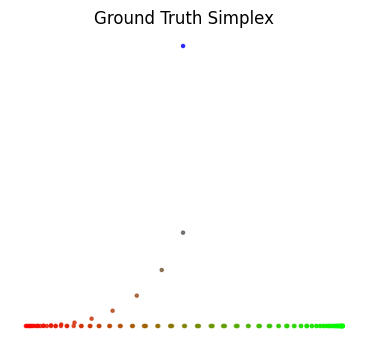

In [5]:
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt

proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
mixed_state_tree = process.derive_mixed_state_presentation(depth=14)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=[k for k in list(msp_belief_index.keys())], alpha=.75, s=5)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()


Transformer training


In [6]:
import torch
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [8]:
def get_transformer_data_from_process(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
    transformer_data = [x for x in tree_paths if len(x) == n_ctx+1]
    transformer_data = torch.tensor(transformer_data)
    transformer_input = transformer_data[:, :-1]
    transformer_target = transformer_data[:, 1:]
    return transformer_input, transformer_target

def get_lower_bound_for_cross_entropy(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    myopic_entropy = mixed_state_tree.myopic_entropy
    return myopic_entropy[1:]

In [9]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 3,
    d_model = 9,
    d_head = 3,
    d_mlp = 9,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=3,
    n_ctx=8,
    init_weights=True,
    device=device,
    seed = 999,
)

In [22]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from typing import List, Tuple, Iterable


class ProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=10000,
                                     fixed=False)
train_dataloader = DataLoader(train_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)
val_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=1000,
                                   fixed=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)

NameError: name 'n_ctx' is not defined

In [11]:
proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
transformer_inputs, transformer_targets = get_transformer_data_from_process(process, cfg.n_ctx)
minimum_loss = np.mean(get_lower_bound_for_cross_entropy(process, cfg.n_ctx))
print(f"Minimum Loss: {minimum_loss}")
transformer_inputs = transformer_inputs.to(device)
transformer_targets = transformer_targets.to(device)

(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0.7]]]
Minimum Loss: 0.6859985357149234


In [12]:
model = HookedTransformer(cfg)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [13]:
from tqdm import tqdm
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in tqdm(range(10000)):
    train_logits = model(transformer_inputs)
    train_loss = loss_fn(train_logits.view(-1, cfg.d_vocab), transformer_targets.flatten())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{10000}, Loss: {train_loss.item()/minimum_loss*100} percent of minimum, LR: {optimizer.param_groups[0]['lr']}")
        scheduler.step()

  0%|          | 10/10000 [00:00<03:41, 45.19it/s]

Epoch 1/10000, Loss: 167.16372051398648 percent of minimum, LR: 0.1


  1%|          | 106/10000 [00:02<03:20, 49.25it/s]

Epoch 101/10000, Loss: 121.71053764922473 percent of minimum, LR: 0.1


  2%|▏         | 207/10000 [00:04<03:20, 48.92it/s]

Epoch 201/10000, Loss: 112.03300781509935 percent of minimum, LR: 0.1


  3%|▎         | 306/10000 [00:06<05:01, 32.13it/s]

Epoch 301/10000, Loss: 109.27813781204902 percent of minimum, LR: 0.1


  4%|▍         | 410/10000 [00:09<03:13, 49.45it/s]

Epoch 401/10000, Loss: 108.24576752121496 percent of minimum, LR: 0.1


  5%|▌         | 508/10000 [00:11<03:13, 49.17it/s]

Epoch 501/10000, Loss: 107.87693041166074 percent of minimum, LR: 0.1


  6%|▌         | 609/10000 [00:13<03:06, 50.25it/s]

Epoch 601/10000, Loss: 107.72360017674191 percent of minimum, LR: 0.1


  7%|▋         | 710/10000 [00:15<03:04, 50.40it/s]

Epoch 701/10000, Loss: 107.64555789363199 percent of minimum, LR: 0.1


  8%|▊         | 810/10000 [00:17<03:13, 47.49it/s]

Epoch 801/10000, Loss: 107.59819555949346 percent of minimum, LR: 0.1


  9%|▉         | 906/10000 [00:20<04:49, 31.43it/s]

Epoch 901/10000, Loss: 107.56556064351028 percent of minimum, LR: 0.1


 10%|█         | 1009/10000 [00:23<03:39, 40.97it/s]

Epoch 1001/10000, Loss: 107.56253696119875 percent of minimum, LR: 0.010000000000000002


 11%|█         | 1105/10000 [00:25<05:43, 25.86it/s]

Epoch 1101/10000, Loss: 107.5598608285782 percent of minimum, LR: 0.010000000000000002


 12%|█▏        | 1206/10000 [00:29<05:43, 25.58it/s]

Epoch 1201/10000, Loss: 107.55724551715356 percent of minimum, LR: 0.010000000000000002


 13%|█▎        | 1306/10000 [00:36<06:09, 23.51it/s]

Epoch 1301/10000, Loss: 107.55469971566711 percent of minimum, LR: 0.010000000000000002


 14%|█▍        | 1405/10000 [00:40<05:50, 24.54it/s]

Epoch 1401/10000, Loss: 107.55220604663431 percent of minimum, LR: 0.010000000000000002


 15%|█▌        | 1505/10000 [00:45<06:00, 23.59it/s]

Epoch 1501/10000, Loss: 107.549790576282 percent of minimum, LR: 0.010000000000000002


 16%|█▌        | 1604/10000 [00:51<05:26, 25.75it/s]

Epoch 1601/10000, Loss: 107.54742723838334 percent of minimum, LR: 0.010000000000000002


 17%|█▋        | 1709/10000 [00:54<02:59, 46.27it/s]

Epoch 1701/10000, Loss: 107.54514209916512 percent of minimum, LR: 0.010000000000000002


 18%|█▊        | 1810/10000 [00:56<02:49, 48.26it/s]

Epoch 1801/10000, Loss: 107.54291778114285 percent of minimum, LR: 0.010000000000000002


 19%|█▉        | 1906/10000 [00:58<02:54, 46.36it/s]

Epoch 1901/10000, Loss: 107.54073690683192 percent of minimum, LR: 0.010000000000000002


 20%|██        | 2003/10000 [01:02<07:22, 18.08it/s]

Epoch 2001/10000, Loss: 107.54050231079052 percent of minimum, LR: 0.0010000000000000002


 21%|██        | 2110/10000 [01:05<02:45, 47.55it/s]

Epoch 2101/10000, Loss: 107.54028509223366 percent of minimum, LR: 0.0010000000000000002


 22%|██▏       | 2209/10000 [01:07<02:39, 48.79it/s]

Epoch 2201/10000, Loss: 107.54007656241906 percent of minimum, LR: 0.0010000000000000002


 23%|██▎       | 2307/10000 [01:09<02:35, 49.35it/s]

Epoch 2301/10000, Loss: 107.53986803260447 percent of minimum, LR: 0.0010000000000000002


 24%|██▍       | 2406/10000 [01:11<02:30, 50.37it/s]

Epoch 2401/10000, Loss: 107.53964212530533 percent of minimum, LR: 0.0010000000000000002


 25%|██▌       | 2511/10000 [01:13<02:28, 50.34it/s]

Epoch 2501/10000, Loss: 107.53943359549073 percent of minimum, LR: 0.0010000000000000002


 26%|██▌       | 2604/10000 [01:16<04:14, 29.07it/s]

Epoch 2601/10000, Loss: 107.53922506567616 percent of minimum, LR: 0.0010000000000000002


 27%|██▋       | 2708/10000 [01:18<02:28, 49.05it/s]

Epoch 2701/10000, Loss: 107.53901653586158 percent of minimum, LR: 0.0010000000000000002


 28%|██▊       | 2810/10000 [01:21<02:31, 47.51it/s]

Epoch 2801/10000, Loss: 107.53879062856244 percent of minimum, LR: 0.0010000000000000002


 29%|██▉       | 2907/10000 [01:23<02:27, 47.99it/s]

Epoch 2901/10000, Loss: 107.53858209874785 percent of minimum, LR: 0.0010000000000000002


 30%|███       | 3009/10000 [01:25<02:20, 49.65it/s]

Epoch 3001/10000, Loss: 107.53858209874785 percent of minimum, LR: 0.00010000000000000003


 31%|███       | 3103/10000 [01:26<02:17, 50.09it/s]

Epoch 3101/10000, Loss: 107.53853865503646 percent of minimum, LR: 0.00010000000000000003


 32%|███▏      | 3210/10000 [01:30<02:47, 40.46it/s]

Epoch 3201/10000, Loss: 107.5385299662942 percent of minimum, LR: 0.00010000000000000003


 33%|███▎      | 3306/10000 [01:32<02:18, 48.18it/s]

Epoch 3301/10000, Loss: 107.53851258880964 percent of minimum, LR: 0.00010000000000000003


 34%|███▍      | 3407/10000 [01:34<02:20, 46.92it/s]

Epoch 3401/10000, Loss: 107.53847783384055 percent of minimum, LR: 0.00010000000000000003


 35%|███▌      | 3509/10000 [01:36<02:18, 46.97it/s]

Epoch 3501/10000, Loss: 107.53846914509828 percent of minimum, LR: 0.00010000000000000003


 36%|███▌      | 3607/10000 [01:38<02:10, 48.88it/s]

Epoch 3601/10000, Loss: 107.53845176761372 percent of minimum, LR: 0.00010000000000000003


 37%|███▋      | 3704/10000 [01:40<03:09, 33.20it/s]

Epoch 3701/10000, Loss: 107.5384257013869 percent of minimum, LR: 0.00010000000000000003


 38%|███▊      | 3808/10000 [01:44<02:11, 47.15it/s]

Epoch 3801/10000, Loss: 107.53840832390236 percent of minimum, LR: 0.00010000000000000003


 39%|███▉      | 3910/10000 [01:46<02:06, 48.08it/s]

Epoch 3901/10000, Loss: 107.53837356893325 percent of minimum, LR: 0.00010000000000000003


 40%|████      | 4009/10000 [01:48<02:01, 49.33it/s]

Epoch 4001/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-05


 41%|████      | 4107/10000 [01:50<02:02, 48.12it/s]

Epoch 4101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 42%|████▏     | 4209/10000 [01:52<01:55, 50.33it/s]

Epoch 4201/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-05


 43%|████▎     | 4305/10000 [01:55<03:02, 31.19it/s]

Epoch 4301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 44%|████▍     | 4407/10000 [01:58<02:16, 41.01it/s]

Epoch 4401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 45%|████▌     | 4505/10000 [02:01<03:06, 29.43it/s]

Epoch 4501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 46%|████▌     | 4605/10000 [02:05<02:58, 30.19it/s]

Epoch 4601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 47%|████▋     | 4706/10000 [02:09<03:07, 28.21it/s]

Epoch 4701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 48%|████▊     | 4808/10000 [02:11<01:41, 50.95it/s]

Epoch 4801/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-05


 49%|████▉     | 4907/10000 [02:13<01:46, 47.90it/s]

Epoch 4901/10000, Loss: 107.53839094641779 percent of minimum, LR: 1.0000000000000004e-05


 50%|█████     | 5008/10000 [02:15<01:43, 48.30it/s]

Epoch 5001/10000, Loss: 107.53839094641779 percent of minimum, LR: 1.0000000000000004e-06


 51%|█████     | 5107/10000 [02:17<01:40, 48.54it/s]

Epoch 5101/10000, Loss: 107.53839094641779 percent of minimum, LR: 1.0000000000000004e-06


 52%|█████▏    | 5206/10000 [02:19<01:40, 47.64it/s]

Epoch 5201/10000, Loss: 107.53839094641779 percent of minimum, LR: 1.0000000000000004e-06


 53%|█████▎    | 5306/10000 [02:23<02:36, 30.08it/s]

Epoch 5301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 54%|█████▍    | 5411/10000 [02:25<01:35, 48.25it/s]

Epoch 5401/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-06


 55%|█████▌    | 5507/10000 [02:27<01:31, 48.96it/s]

Epoch 5501/10000, Loss: 107.53839094641779 percent of minimum, LR: 1.0000000000000004e-06


 56%|█████▌    | 5607/10000 [02:29<01:27, 50.46it/s]

Epoch 5601/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-06


 57%|█████▋    | 5706/10000 [02:31<01:33, 45.94it/s]

Epoch 5701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 58%|█████▊    | 5803/10000 [02:33<01:37, 43.20it/s]

Epoch 5801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 59%|█████▉    | 5907/10000 [02:36<01:45, 38.96it/s]

Epoch 5901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 60%|██████    | 6006/10000 [02:38<01:23, 48.07it/s]

Epoch 6001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 61%|██████    | 6110/10000 [02:40<01:19, 48.88it/s]

Epoch 6101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 62%|██████▏   | 6206/10000 [02:42<01:15, 50.04it/s]

Epoch 6201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 63%|██████▎   | 6307/10000 [02:44<01:17, 47.83it/s]

Epoch 6301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 64%|██████▍   | 6407/10000 [02:46<01:45, 34.07it/s]

Epoch 6401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 65%|██████▌   | 6507/10000 [02:50<01:17, 44.85it/s]

Epoch 6501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 66%|██████▌   | 6609/10000 [02:52<01:11, 47.70it/s]

Epoch 6601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 67%|██████▋   | 6707/10000 [02:54<01:07, 48.43it/s]

Epoch 6701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 68%|██████▊   | 6808/10000 [02:56<01:06, 47.68it/s]

Epoch 6801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 69%|██████▉   | 6907/10000 [02:58<01:02, 49.57it/s]

Epoch 6901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 70%|███████   | 7007/10000 [03:01<01:36, 31.18it/s]

Epoch 7001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 71%|███████   | 7110/10000 [03:04<00:57, 50.54it/s]

Epoch 7101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 72%|███████▏  | 7206/10000 [03:05<00:55, 50.33it/s]

Epoch 7201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 73%|███████▎  | 7308/10000 [03:07<00:53, 50.65it/s]

Epoch 7301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 74%|███████▍  | 7409/10000 [03:10<00:49, 51.87it/s]

Epoch 7401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 75%|███████▌  | 7509/10000 [03:12<00:52, 47.09it/s]

Epoch 7501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 76%|███████▌  | 7603/10000 [03:16<02:30, 15.98it/s]

Epoch 7601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 77%|███████▋  | 7706/10000 [03:20<01:15, 30.20it/s]

Epoch 7701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 78%|███████▊  | 7808/10000 [03:22<00:44, 49.50it/s]

Epoch 7801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 79%|███████▉  | 7909/10000 [03:24<00:43, 48.01it/s]

Epoch 7901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 80%|████████  | 8006/10000 [03:27<01:03, 31.23it/s]

Epoch 8001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 81%|████████  | 8109/10000 [03:31<00:42, 44.73it/s]

Epoch 8101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 82%|████████▏ | 8206/10000 [03:35<01:03, 28.35it/s]

Epoch 8201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 83%|████████▎ | 8305/10000 [03:38<01:00, 28.01it/s]

Epoch 8301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 84%|████████▍ | 8404/10000 [03:44<01:02, 25.41it/s]

Epoch 8401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 85%|████████▌ | 8504/10000 [03:47<00:50, 29.66it/s]

Epoch 8501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 86%|████████▌ | 8605/10000 [03:51<00:46, 29.81it/s]

Epoch 8601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 87%|████████▋ | 8704/10000 [03:54<00:38, 33.61it/s]

Epoch 8701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 88%|████████▊ | 8806/10000 [03:57<00:25, 47.34it/s]

Epoch 8801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 89%|████████▉ | 8906/10000 [03:59<00:22, 48.81it/s]

Epoch 8901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 90%|█████████ | 9010/10000 [04:01<00:20, 49.37it/s]

Epoch 9001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 91%|█████████ | 9110/10000 [04:03<00:17, 49.70it/s]

Epoch 9101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 92%|█████████▏| 9211/10000 [04:05<00:15, 50.45it/s]

Epoch 9201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 93%|█████████▎| 9304/10000 [04:08<00:21, 31.88it/s]

Epoch 9301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 94%|█████████▍| 9410/10000 [04:10<00:12, 47.48it/s]

Epoch 9401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 95%|█████████▌| 9510/10000 [04:13<00:10, 47.13it/s]

Epoch 9501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 96%|█████████▌| 9607/10000 [04:15<00:08, 47.86it/s]

Epoch 9601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 97%|█████████▋| 9709/10000 [04:17<00:05, 50.36it/s]

Epoch 9701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 98%|█████████▊| 9806/10000 [04:19<00:04, 48.38it/s]

Epoch 9801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 99%|█████████▉| 9904/10000 [04:21<00:03, 31.17it/s]

Epoch 9901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


100%|██████████| 10000/10000 [04:24<00:00, 37.83it/s]


In [14]:
import torch


# 保存整个模型到当前工作目录
torch.save(model, 'my_model.pth')



In [15]:
!ls -l


total 52
drwxr-xr-x 8 root root  4096 Jun  2 19:51 epsilon-transformers
drwxr-xr-x 8 root root  4096 Jun  2 17:28 epsilon_transformers
drwxr-xr-x 2 root root  4096 Jun  2 19:55 epsilon_transformers.egg-info
drwxr-xr-x 2 root root  4096 Jun  2 17:26 examples
-rw-r--r-- 1 root root 19574 Jun  2 20:01 my_model.pth
-rw-r--r-- 1 root root   584 Jun  2 17:26 pyproject.toml
-rw-r--r-- 1 root root  2686 Jun  2 17:26 README.md
drwxr-xr-x 2 root root  4096 Jun  2 17:26 scripts
drwxr-xr-x 2 root root  4096 Jun  2 17:26 tests


In [16]:
# 加载模型
loaded_model = torch.load('my_model.pth')

# 检查模型是否相同
# 这可以通过比较某些输出或模型参数来进行
input_example = torch.randint(low=0, high=proc1.vocab_len, size=(1, 8))  # 假设词汇表大小为vocab_size
input_example = input_example.long()  # 转换输入数据类型
original_output = model(input_example)
loaded_output = loaded_model(input_example)
print(torch.equal(original_output, loaded_output))  # 输出应该是 True


True


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == cfg.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])


tensor([[0, 0, 2, 2, 0, 0, 0, 0],
        [0, 0, 2, 2, 0, 0, 0, 2],
        [0, 2, 2, 0, 0, 2, 0, 0],
        [0, 2, 2, 0, 0, 2, 0, 2],
        [0, 1, 0, 1, 1, 1, 1, 0]], dtype=torch.int32)


In [18]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")


Transformer Input Beliefs: torch.Size([511, 8, 3]), Transformer Input Belief Indices: torch.Size([511, 8])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('my_model.pth')
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
print(activations.keys())


dict_keys(['blocks.0.hook_resid_post'])


In [20]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions


In [21]:
acts = torch.cat([v for k, v in activations.items()], dim=-1)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(f"Shape of belief_predictions: {belief_predictions.shape}")

Shape of belief_predictions: (511, 8, 3)


In [24]:
from epsilon_transformers.visualization import plots
print(dir(plots))


['Figure', 'Float', 'Image', 'Literal', 'RawModelConfig', 'ZeroOneR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_project_to_simplex', 'find_msp_subspace_in_residual_stream', 'fire', 'np', 'pd', 'plt']


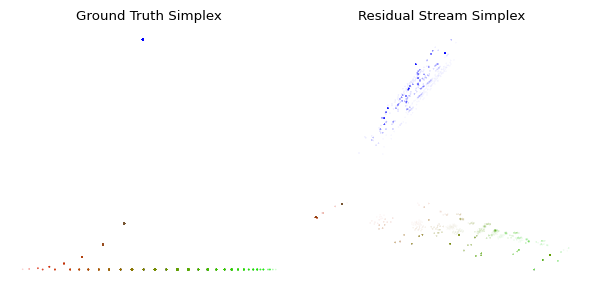

In [30]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()